In [1]:
import numpy as np
import pandas as pd
import turicreate as tc
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

In [3]:
df = pd.read_csv('kc_house_data.csv', dtype = dtype_dict)
sf = tc.SFrame('m_1ce96d9d245ca490.frame_idx')

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # add a constant column to an SFrame
    # prepend variable 'constant' to the features list
    features = ['constant'] + features
    # select the columns of data_SFrame given by the ‘features’ list into the SFrame ‘features_sframe’
    features_sframe = data_sframe[features]
    # this will convert the features_sframe into a numpy matrix:
    features_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the target to the variable ‘output_sarray’
    output_sarray = data_sframe[output]
    # this will convert the SArray into a numpy array:
    output_array = output_sarray.to_numpy()
    return(features_matrix, output_array)

def predict_output(feature_matrix, weights):
    predictions = np.matmul(feature_matrix, weights)
    return(predictions)

def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    derivative = 0
    if feature_is_constant == False:
        derivative = (2. * np.dot(feature, errors)) + 2. * l2_penalty * weight
    else:
        derivative = 2. * np.dot(feature, errors)
    return derivative

def feature_derivative(errors, feature):
    derivative = -2 * np.dot(feature, errors)
    return(derivative)

def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False
    weights = np.array(initial_weights)
    while not converged:
        # compute the predictions based on feature_matrix and weights:
        predictions = predict_outcome(feature_matrix, weights)
        # compute the errors as predictions - output:
        errors = np.subtract(predictions, output)
        
        gradient_sum_squares = 0 # initialize the gradient
        # while not converged, update each weight individually:
        for i in range(len(weights)):
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(errors, feature_matrix[:, i])
            # add the squared derivative to the gradient magnitude
            gradient_sum_squares += np.square(derivative)
            # update the weight based on step size and derivative:
            
            weights[i] = weights[i] - (step_size * derivative)
        gradient_magnitude = np.sqrt(gradient_sum_squares)
        
        if gradient_magnitude < tolerance:
            converged = True
    return(weights)

def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
        #while not reached maximum number of iterations:
    num_iter = 0
    
    while num_iter < max_iterations:
        # compute the predictions using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = np.subtract(predictions, output)
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            derivative = 0
            if i == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight
            
            weights[i] = weights[i] - step_size * derivative
        num_iter += 1
    return weights

In [5]:
(example_features, example_output) = get_numpy_data(sf, ['sqft_living'], 'price')
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights)
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print (np.sum(errors*example_features[:,1])*2+20.)
print ("")

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2)

-56554166782350.0
-56554166782350.0

-22446749336.0
-22446749336.0


In [6]:
train_data,test_data = sf.random_split(.8,seed=0)


In [7]:
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [ ]:
simple_feature_matrix

In [8]:
L2_0_Penalty = 0.0
step_size = 1e-12
max_iterations = 1000
initial_weights = np.zeros(simple_feature_matrix.ndim)

In [9]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             L2_0_Penalty, max_iterations)

In [10]:
L2_High_Penalty = 1e11
step_size = 1e-12
max_iterations = 1000
initial_weights = np.zeros(simple_feature_matrix.ndim)

In [11]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             L2_High_Penalty, max_iterations)

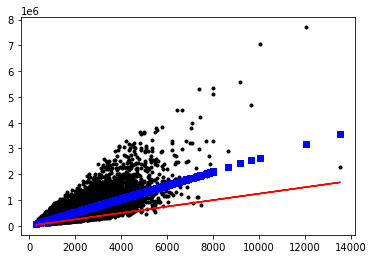

In [12]:
plt.plot(simple_feature_matrix[:,1],output,'k.',
        simple_feature_matrix[:,1],predict_output(simple_feature_matrix, simple_weights_0_penalty),'bs',
        simple_feature_matrix[:,1],predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [13]:
print(simple_weights_0_penalty)
print(simple_weights_high_penalty)

[-1.63113501e-01  2.63024369e+02]
[  9.76730383 124.57217565]


In [14]:
RSS_no = np.sum(np.square(np.subtract(predict_output(simple_test_feature_matrix, simple_weights_0_penalty), test_output)))
RSS_high = np.sum(np.square(np.subtract(predict_output(simple_test_feature_matrix, simple_weights_high_penalty), test_output)))
print("RSS no regularization = %.4E\nRSS high regularization = %.4E\n" % (RSS_no, RSS_high))

RSS no regularization = 2.7572E+14
RSS high regularization = 6.9464E+14



In [15]:
model_features = ['sqft_living', 'sqft_living15']
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)
num_row, num_cols = feature_matrix.shape
initial_weights = np.zeros(num_cols)
stepsize = 1e-12
max_iterations = 1000

In [16]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                             initial_weights, stepsize, 
                                                             L2_0_Penalty, max_iterations)

In [17]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                             initial_weights, stepsize, 
                                                             L2_High_Penalty, max_iterations)

In [18]:
print("%.1f" % multiple_weights_0_penalty[1])
print("%.1f" % multiple_weights_high_penalty[1])

243.1
91.5


In [19]:
RSS_init = np.sum(np.square(np.subtract(predict_output(test_feature_matrix, initial_weights), test_output)))
RSS_zero = np.sum(np.square(np.subtract(predict_output(test_feature_matrix, multiple_weights_0_penalty), test_output)))
RSS_vh = np.sum(np.square(np.subtract(predict_output(test_feature_matrix, multiple_weights_high_penalty), test_output)))
print("RSS_init = %.4E\nRSS no regularization = %.4E\nRSS high regularization = %.4E\n" % (RSS_init, RSS_zero, RSS_vh))

RSS_init = 1.7843E+15
RSS no regularization = 2.7407E+14
RSS high regularization = 5.0040E+14



In [29]:
a = np.square(np.dot(test_feature_matrix[0], multiple_weights_0_penalty) - test_output[0])

In [30]:
b = np.square(np.dot(test_feature_matrix[0], multiple_weights_high_penalty) - test_output[0])

In [31]:
a>b

True